In [2]:
import torch

In [3]:
import pandas as pd

In [4]:
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

In [5]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# torch.manual_seed(42)

In [6]:
import mlflow.pytorch

In [7]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


## Dataset Creation

https://github.com/quarkslab/dataset-call-graph-blogpost-material

https://colab.research.google.com/drive/17JFlnMUjcsMmXQYXF8xZ3z169VDAwUls?authuser=1

https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=9

https://github.com/deepfindr/gnn-project

In [8]:
# test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)

In [9]:
import pickle
path_temp= "dataset-call-graph-blogpost-material/dataset/"

In [10]:
good_data=pickle.load(open(path_temp+"goodware_graphs.p","rb"))
bad_data=pickle.load(open(path_temp+"malware_graphs.p","rb"))

In [11]:
print("length of array = ",len(good_data))
print("length of 1 item = ",len(good_data[0]))
print("length of first thing in one item = ",len(good_data[0][0]))
print("length of second thing in one item = ",len(good_data[0][1]))

length of array =  546
length of 1 item =  2
length of first thing in one item =  464
length of second thing in one item =  464


In [12]:
node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

In [73]:

class MoleculeDataset(Dataset):
    def __init__(self, root, filename,good_data, bad_data, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.good_data=good_data
        self.bad_data=bad_data
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data_passed=self.good_data+self.bad_data
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return ["goodware_graphs.p","malware_graphs.p"]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
#         self.data = self.data_passed
        return "NOt implemented yet"

        # if self.test:
        #     return [f'data_test_{i}.pt' for i in list(self.data.index)]
        # else:
        #     return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
#         self.data = self.data_passed
        print("started doing stuff")
        index=0

        for mol in (self.good_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 1

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        for mol in (self.bad_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 0

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        

    def process_node_features(self,val, node_feature_menu):
      # print("jj")
      # print(val)
      node_out=[]
      keys=val.keys()
      for name in node_feature_menu : 
        if(name in keys):
          node_out.append(val[name])
        else:
          node_out.append(0)
      return node_out


    def _get_node_features(self, node_features,instr_index):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

        all_node_feats = []

        for atom in node_features:
            # print("atom is",atom)
            
            node_feats = []
            node_feats = self.process_node_features(node_features[atom],node_feature_menu)
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        all_node_feats = np.transpose(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # for bond in mol.GetBonds():
        #     edge_feats = []
        #     # Feature 1: Bond type (as double)
        #     edge_feats.append(bond.GetBondTypeAsDouble())
        #     # Feature 2: Rings
        #     edge_feats.append(bond.IsInRing())
        #     # Append node features to matrix (twice, per direction)
        #     all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_one_instr_adjacency(self,val,instr_index,self_instruction_number):
        edge_val=[]
        for a in val:
            edge_val+=[[instr_index[self_instruction_number],instr_index[a]]]

        return edge_val

    def _get_adjacency_info(self, mol, instr_index):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol:
            edge_indices += self.get_one_instr_adjacency(mol[bond],instr_index,bond)

        # print("--------")
        # print(len(edge_indices))
        # print(len(edge_indices[0]))
        # print(len(edge_indices[1]))
        # print(edge_indices)
        # edge_indices = torch.tensor(edge_indices)
        # edge_indices = edge_indices.t().to(torch.long).view(2, -1)

        np_edge=np.array(edge_indices)
        np_edge=np.transpose(np_edge)
        tr_edge=torch.tensor(np_edge, dtype=torch.long)


        return tr_edge

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
#         return self.data_pass.shape[0]
        return len(self.data_passed)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        data = torch.load(os.path.join(self.processed_dir, 
                             f'data_{idx}.pt'))
        return data





In [74]:
train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)

Processing...


started doing stuff


Done!


In [75]:
test_cut_dataset=train_dataset[526:566]
train_cut_dataset= train_dataset[:526]+train_dataset[566:]

In [79]:
from torch_geometric.data import DataLoader

#%% Prepare training
# NUM_GRAPHS_PER_BATCH = 10
NUM_GRAPHS_PER_BATCH = 1

train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH,
                     shuffle=False,
                         num_workers=0)
test_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH,
                     shuffle=False)


In [60]:
# from torch_geometric.data import DataLoader

# #%% Prepare training
# NUM_GRAPHS_PER_BATCH = 10
# # NUM_GRAPHS_PER_BATCH = 1

# train_loader = DataLoader(train_cut_dataset, 
#                     batch_size=NUM_GRAPHS_PER_BATCH,
#                      shuffle=False,
#                          num_workers=0)
# test_loader = DataLoader(test_cut_dataset, 
#                     batch_size=NUM_GRAPHS_PER_BATCH,
#                      shuffle=False)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## MODEL

In [54]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
# torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 256

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # # Linear layers
        # self.linear1 = Linear(embedding_size*2, 1024)
        # self.linear2 = Linear(1024, 512)
        # self.linear3 = Linear(512, num_classes)  

            # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024 , 512)  
        self.linear3 = Linear(512, 128)  
        self.linear4 = Linear(128, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        # x = self.linear1(x).relu()
        # x = F.dropout(x, p=0.15, training=self.training)
        # x = self.linear2(x)
        # x = F.dropout(x, p=0.15, training=self.training)
        # x = self.linear3(x)


        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear2(x)
        # x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear3(x)
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear4(x)

         
        #         # Linear layers
        # self.linear1 = Linear(embedding_size*2, 1024)
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear2 = Linear(1024 , 512)  
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear3 = Linear(512, 128)  
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear4 = Linear(128, num_classes)  

        return x


In [55]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import mlflow.pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [82]:
device="cpu"

In [83]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 2463874


GNN(
  (conv1): GATConv(464, 256, heads=3)
  (head_transform1): Linear(in_features=768, out_features=256, bias=True)
  (pool1): TopKPooling(256, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(256, 256, heads=3)
  (head_transform2): Linear(in_features=768, out_features=256, bias=True)
  (pool2): TopKPooling(256, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(256, 256, heads=3)
  (head_transform3): Linear(in_features=768, out_features=256, bias=True)
  (pool3): TopKPooling(256, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=2, bias=True)
)

In [84]:
#%% Loss and Optimizer
# original loss
weights = torch.tensor([1, 1.2], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# loss in the second gnn
# weight  = torch.tensor([1.3], dtype=torch.float32).to(device)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)


# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)  
# optimizer = torch.optim.Adam(model.parameters(),lr=0.0005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.08)


In [85]:
def test(epoch):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch
                        ) 
        loss = torch.sqrt(loss_fn(pred, batch.y))    
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
        
    try:
        mlflow.log_metric(key=f"accuracy-{type}", value=float(accuracy_score(y_pred, y_true)), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"Accuracy: notdefined")

In [86]:

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients

        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch
                                ) 
        # Calculating the loss and gradients
#         loss = torch.sqrt(loss_fn(pred, batch.y)) 
        loss_v1 = loss_fn(pred, batch.y) 
        loss_v2=torch.sqrt(loss_v1)
#         print("batch.y")
#         print(batch.y)
        
#         print("pred")
#         print(pred)
        
#         print("loss_v1")
#         print(loss_v1)
#         print("loss_v2")
#         print(loss_v2)
        
        loss=loss_v2
        loss.backward()  
        
        # this is the additional clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=7.0)
        
        
        # Update using the gradients
        optimizer.step()  


        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss




In [100]:
from torch_geometric.data import DataLoader

#%% Prepare training
NUM_GRAPHS_PER_BATCH = 2
# NUM_GRAPHS_PER_BATCH = 1

train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH,
                     shuffle=False,
                         num_workers=0)
test_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH,
                     shuffle=False)
device="cpu"

In [106]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(1):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 10 == 0 and epoch !=0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



  0%|          | 0/681 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 464 but got size 492 for tensor number 1 in the list.

In [103]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
# torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 256

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # # Linear layers
        # self.linear1 = Linear(embedding_size*2, 1024)
        # self.linear2 = Linear(1024, 512)
        # self.linear3 = Linear(512, num_classes)  

            # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024 , 512)  
        self.linear3 = Linear(512, 128)  
        self.linear4 = Linear(128, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        # x = self.linear1(x).relu()
        # x = F.dropout(x, p=0.15, training=self.training)
        # x = self.linear2(x)
        # x = F.dropout(x, p=0.15, training=self.training)
        # x = self.linear3(x)


        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear2(x)
        # x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear3(x)
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.linear4(x)

         
        #         # Linear layers
        # self.linear1 = Linear(embedding_size*2, 1024)
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear2 = Linear(1024 , 512)  
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear3 = Linear(512, 128)  
        # x = F.dropout(x, p=0.15, training=self.training)
        # self.linear4 = Linear(128, num_classes)  

        return x


In [105]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[0]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 2128258


GNN(
  (conv1): GATConv(27, 256, heads=3)
  (head_transform1): Linear(in_features=768, out_features=256, bias=True)
  (pool1): TopKPooling(256, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(256, 256, heads=3)
  (head_transform2): Linear(in_features=768, out_features=256, bias=True)
  (pool2): TopKPooling(256, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(256, 256, heads=3)
  (head_transform3): Linear(in_features=768, out_features=256, bias=True)
  (pool3): TopKPooling(256, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=2, bias=True)
)

In [107]:
# for i in range(len(train_dataset)):
for i in range(20):
    print(train_dataset[i].x.size(),train_dataset[i].edge_index.size())

torch.Size([27, 464]) torch.Size([2, 821])
torch.Size([27, 492]) torch.Size([2, 1217])
torch.Size([27, 485]) torch.Size([2, 925])
torch.Size([27, 440]) torch.Size([2, 792])
torch.Size([27, 465]) torch.Size([2, 836])
torch.Size([27, 468]) torch.Size([2, 855])
torch.Size([27, 440]) torch.Size([2, 792])
torch.Size([27, 587]) torch.Size([2, 1083])
torch.Size([27, 1137]) torch.Size([2, 3479])
torch.Size([27, 478]) torch.Size([2, 866])
torch.Size([27, 1024]) torch.Size([2, 2837])
torch.Size([27, 481]) torch.Size([2, 690])
torch.Size([27, 488]) torch.Size([2, 928])
torch.Size([27, 322]) torch.Size([2, 354])
torch.Size([27, 1122]) torch.Size([2, 2241])
torch.Size([27, 559]) torch.Size([2, 982])
torch.Size([27, 1643]) torch.Size([2, 4396])
torch.Size([27, 568]) torch.Size([2, 1731])
torch.Size([27, 463]) torch.Size([2, 816])
torch.Size([27, 484]) torch.Size([2, 925])


In [ ]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

2022/04/25 11:31:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JERRYJ~1\AppData\Local\Temp\tmpydnacwnv\model\data, flavor: pytorch), fall back to return ['torch==1.11.0', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.
D:\Anaconda3\envs\pytorch\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/7cfc71d98fa2456886482425d2a7e6da/model', model_uuid='2e48ec66886e4b2893c12a20fc26346c', run_id='7cfc71d98fa2456886482425d2a7e6da', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-25 06:01:21.262028', mlflow_version='1.25.1')

In [89]:
mlflow.end_run()


Confusion Matrix

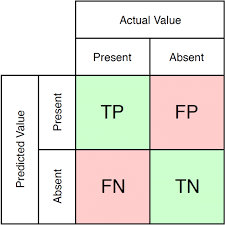

In [48]:
# model_type_name="GNn_expainer_model1_2_epoch_74acc"
model_type_name="corrected_model_GNn_expainer_model1epoch_cpu_63acc"

In [49]:
from datetime import date
from datetime import datetime


In [50]:
# SAVE MODEL
#  pls create a folder named model_saved if not there
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H_%M_%S")
PATH_to_save_model="model_saved/"+"model_"+dt_string+":"+model_type_name+".pt"
PATH_to_save_model="model_saved/model "+dt_string+model_type_name+".pt"
torch.save(model, PATH_to_save_model)

In [166]:
# # Model class must be defined somewhere
# model2 = torch.load(PATH_to_save_model)
# model2.eval()

In [140]:
PATH_to_save_model

'model_saved/model 24_04_2022 00_47_21crazy_adam_acc66.pt'

In [168]:
mlflow.end_run()

In [47]:
from torch_geometric.nn import GNNExplainer
# Initialize explainer
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
graph = train_dataset[0]

In [48]:
node_feat_mask, edge_mask = explainer.explain_graph(graph.x, graph.edge_index, batch_index=10)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 464 but got size 2 for tensor number 1 in the list.

In [24]:
print(x.device)

NameError: name 'x' is not defined

In [60]:
len(graph.edge_index)

2

In [ ]:
# train 
# explainability

In [77]:
# for i in range(len(train_dataset)):
for i in range(20):
    print(train_dataset[i].x.size(),train_dataset[i].edge_index.size())

torch.Size([27, 464]) torch.Size([2, 821])
torch.Size([27, 492]) torch.Size([2, 1217])
torch.Size([27, 485]) torch.Size([2, 925])
torch.Size([27, 440]) torch.Size([2, 792])
torch.Size([27, 465]) torch.Size([2, 836])
torch.Size([27, 468]) torch.Size([2, 855])
torch.Size([27, 440]) torch.Size([2, 792])
torch.Size([27, 587]) torch.Size([2, 1083])
torch.Size([27, 1137]) torch.Size([2, 3479])
torch.Size([27, 478]) torch.Size([2, 866])
torch.Size([27, 1024]) torch.Size([2, 2837])
torch.Size([27, 481]) torch.Size([2, 690])
torch.Size([27, 488]) torch.Size([2, 928])
torch.Size([27, 322]) torch.Size([2, 354])
torch.Size([27, 1122]) torch.Size([2, 2241])
torch.Size([27, 559]) torch.Size([2, 982])
torch.Size([27, 1643]) torch.Size([2, 4396])
torch.Size([27, 568]) torch.Size([2, 1731])
torch.Size([27, 463]) torch.Size([2, 816])
torch.Size([27, 484]) torch.Size([2, 925])


In [60]:
train_dataset[i].edge_index

tensor([[  0,   0,   0,  ..., 559, 560, 561],
        [531, 546, 254,  ..., 120, 522, 523]])

In [65]:
# train_dataset[i].x
# len(train_dataset[i].x)
# train_dataset[0].x.size()
train_dataset[0].x.size()


torch.Size([464, 27])

In [30]:
train_dataset[i].edge_attr

tensor([])

In [31]:
train_dataset[i].y

1